In [1]:
import gym
import ma_gym 
import numpy as np
import random
import pandas as pd
from ma_gym.envs.traffic_junction import TrafficJunction  
from collections import defaultdict
import nashpy as nash
from dqn import DQNAgent
import matplotlib.pyplot as plt
from ppo import PPOAgent
import seaborn as sns
from scipy.stats import ttest_ind, kstest, gamma, lognorm, norm

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-xi2guhnb because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
seeds = [42, 135]



## 4 Agents

In [3]:
from main import simulation_10_agents, simulation_4_agents, simulation_10_to_4_agents
import copy
window_size = 70 
window_size2 = 20


avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f = None, None, None, None, None, None, None, None
for seed in seeds:
    avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs = simulation_4_agents(seed, False) 
    if seed == seeds[0]:
        avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f= avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs
        first_gen_results_f = [list(item) for item in first_gen_results_f]
        middle_gen_results_f = [list(item) for item in middle_gen_results_f]
        last_gen_results_f = [list(item) for item in last_gen_results_f]
    
    else:
        avg_training_rewards_f = [sum(x) / 2 for x in zip(avg_training_rewards_f, avg_training_rewards)]
       
        avg_episode_costs_f = [sum(x) / 2 for x in zip(avg_episode_costs_f, avg_episode_costs)]

        first_gen_results_f[0][0] = [sum(x) / 2 for x in zip(first_gen_results_f[0][0], first_gen_results[0][0])]
        middle_gen_results_f[0][0] = [sum(x) / 2 for x in zip(middle_gen_results_f[0][0], middle_gen_results[0][0])]
        last_gen_results_f[0][0] = [sum(x) / 2 for x in zip(last_gen_results_f[0][0], last_gen_results[0][0])]

        avg_training_norm_violations_f = avg_training_norm_violations_f.add(avg_training_norm_violations).div(2)
        
        first_gen_results_f[0][1] = first_gen_results_f[0][1].add(first_gen_results[0][1]).div(2)
        middle_gen_results_f[0][1] = middle_gen_results_f[0][1].add(middle_gen_results[0][1]).div(2)
        last_gen_results_f[0][1] = last_gen_results_f[0][1].add(last_gen_results[0][1]).div(2)

        sim_violated_f = sim_violated_f.add(sim_violated).div(2)
        at_dest_f = [sum(x) / 2 for x in zip(at_dest_f, at_dest)]

avg_results = pd.Series(avg_training_rewards_f).ewm(span=125).mean()
first_results = pd.Series(first_gen_results_f[0][0]).ewm(span=125).mean()   
middle_results = pd.Series(middle_gen_results_f[0][0]).ewm(span=125).mean()
last_results = pd.Series(last_gen_results_f[0][0]).ewm(span=125).mean()
print(f"Last results: {last_gen_results_f[0][0]}")
print(f"Last results series: {last_results}")
plt.plot(avg_training_rewards_f, label='Average training reward')
plt.plot(first_results, label='First generation reward')
plt.plot(middle_results, label='Middle generation reward')
plt.plot(last_results, label='Last generation reward')
plt.legend()
plt.title('Average training reward')
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()

avg_episode_costs_f = [-1 * x for x in avg_episode_costs_f]
avg_episode_costs_f = pd.Series(avg_episode_costs_f).ewm(span=125).mean()
first_gen_results_f[0][2] = [-1 * x for x in first_gen_results_f[0][2]]
first_gen_results_f[0][2] = pd.Series(first_gen_results_f[0][2]).ewm(span=125).mean()
middle_gen_results_f[0][2] = [-1 * x for x in middle_gen_results_f[0][2]]
middle_gen_results_f[0][2] = pd.Series(middle_gen_results_f[0][2]).ewm(span=125).mean()
last_gen_results_f[0][2] = [-1 * x for x in last_gen_results_f[0][2]]
last_gen_results_f[0][2] = pd.Series(last_gen_results_f[0][2]).ewm(span=125).mean()
plt.plot(avg_episode_costs_f, label='Average episode cost')
plt.plot(first_gen_results_f[0][2], label='First generation cost')
plt.plot(middle_gen_results_f[0][2], label='Middle generation cost')
plt.plot(last_gen_results_f[0][2], label='Last generation cost')
plt.legend()
plt.title('Average episode cost')
plt.xlabel('Episodes')
plt.ylabel('Average cost')
plt.show()

first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("seed", axis=1)
first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("total_violations_cost", axis=1)
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("seed", axis=1)    
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("total_violations_cost", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("seed", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("total_violations_cost", axis=1)


avg_training_norm_violations_f = avg_training_norm_violations_f.drop("seed", axis=1)   
avg_training_norm_violations_f = avg_training_norm_violations_f.drop("total_violations_cost", axis=1)

violation_counts = avg_training_norm_violations_f.sum()
violation_counts = violation_counts.clip(lower=0)
plt.pie(violation_counts, autopct='%1.1f%%')
plt.title('Violation Count')
plt.legend(violation_counts.index, title="Violations From Training", loc="best")


costs_from_violations_f = copy.deepcopy(sim_violated_f['total_violations_cost'])
sim_violated_f.drop(columns=['seed'], inplace=True)
sim_violated_f.drop(columns=['total_violations_cost'], inplace=True)
costs_from_violations = -1 * costs_from_violations_f
costs_from_violations_smooth = pd.Series(costs_from_violations).rolling(window=window_size2).mean()

sns.histplot(costs_from_violations, kde=True)
plt.title('Distribution of Costs from Violations Simulation')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

data = costs_from_violations

shape, loc, scale = gamma.fit(data)

x = np.linspace(min(data), max(data), 10000)

pdf = gamma.pdf(x, shape, loc, scale)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Gamma PDF')
plt.legend()
plt.show()

# Perform the Kolmogorov-Smirnov test
d, p_value = kstest(data, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
mean = np.mean(data)
std_dev = np.std(data)

# Calculate the percentiles
percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")

#LOG-NORMAL
# Fit the log-normal distribution to your data
shape, loc, scale = lognorm.fit(data)

# Generate the log-normal PDF with the parameters obtained from the fit
pdf = lognorm.pdf(x, shape, loc, scale)

# Plot the histogram of your data and the log-normal PDF
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Log-normal PDF')
plt.legend()
plt.show()

# Perform the Kolmogorov-Smirnov test
d, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
mean = np.mean(data)
std_dev = np.std(data)

# Calculate the percentiles
percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")


#simulation at destination, avg timeto destination
#simulation at destination, avg timeto destination
at_dest_f = np.array(at_dest_f)
sns.histplot(at_dest_f, kde=True)
plt.title('Distribution of Average Steps to Destination')
plt.xlabel('Steps')
plt.ylabel('Density')
plt.show()

mean = np.mean(at_dest_f)
std_dev = np.std(at_dest_f)
percentiles = np.percentile(at_dest_f, [25, 50, 75])
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
skewness = (3*(mean - np.median(at_dest_f)))/std_dev
print(f"Skewness: {skewness}")
kurtosis = (np.mean((at_dest_f - np.mean(at_dest_f))**4)/(np.mean((at_dest_f - np.mean(at_dest_f))**2)))-3
print(f"Kurtosis: {kurtosis}")


pdf_lognorm = lognorm.pdf(x, shape, loc, scale)

mean, std_dev = np.mean(data), np.std(data)
pdf_gaussian = norm.pdf(x, mean, std_dev)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Distirbution of Costs from Violations Simulation')
plt.plot(x, pdf_gaussian, 'b-', label='Gaussian PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'norm', args=(mean, std_dev))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")

print(f"The mean of the normal distribution is {mean}")
print(f"The 25th percentile of the normal distribution is {norm.ppf(0.25, mean, std_dev)}")
print(f"The 50th percentile of the normal distribution is {norm.ppf(0.50, mean, std_dev)}")
print(f"The 75th percentile of the normal distribution is {norm.ppf(0.75, mean, std_dev)}")
print(f"The 95th percentile of the normal distribution is {norm.ppf(0.95, mean, std_dev)}")
print(f"The 99th percentile of the normal distribution is {norm.ppf(0.99, mean, std_dev)}")





df = pd.DataFrame({
    'costs_from_violations_smooth': costs_from_violations,
    'at_dest_f': at_dest_f
})

# Calculate the correlation
correlation = df['costs_from_violations_smooth'].corr(df['at_dest_f'])

print(f"The correlation between 'costs_from_violations_smooth' and 'at_dest_f' is {correlation}")
violation_counts = sim_violated_f.sum()


plt.pie(violation_counts, autopct='%1.1f%%')

plt.title('Violation Count')

plt.legend(violation_counts.index, title="Violations", loc="best")

plt.show()



/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Generation 1/300
Solving for Nash Equilibrium in Generation 1/300
Computing Nash Equilibrium for 16 matches
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100


/Users/gabesmithline/Desktop/semester6/RL/project/ppo.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  states = torch.FloatTensor(states)


Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Episode 62/100
Episode 63/100
Episode 64/100
Episode 65/100
Episode 66/100
Episode 67/100
Episode 68/100
Episode 69/100
Episode 70/100
Episode 71/100
Episode 72/100

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_82270/3285797726.py", line 9, in <module>
    avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs = simulation_4_agents(seed, False)
                                                                                                                                                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gabesmithline/Desktop/semester6/RL/project/main.py", line 328, in simulation_4_agents
    agents, avg_rewards_training, avg_training_norm_violations, first_gen_results, middle_gen_results, last_gen_results, avg_episode_cost = psro_simulation(env, generations, episodes, "Nash", seed, info_training)
  

## 10 Agents to 4 Transfer

Generation 1/300


/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Solving for Nash Equilibrium in Generation 1/300
Computing Nash Equilibrium for 100 matches
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Ep

/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 7 done
Episode 8 done
Episode 8 done
Total steps: 13
Episode 9 done
Episode 10 done
Episode 11 done
Episode 11 done
Total steps: 13
Episode 12 done
Episode 13 done
Episode 14 done
Episode 15 done
Episode 15 done
Total steps: 1
Episode 16 done
Episode 16 done
Total steps: 13
Episode 17 done
Episode 18 done
Episode 19 done
Episode 20 done
Episode 20 done
Total steps: 13
Episode 21 done
Episode 22 done
Episode 23 done
Episode 24 done
Episode 25 done
Episode 26 done
Episode 27 done
Episode 28 done
Episode 29 done
Episode 30 done
Episode 31 done
Episode 32 done
Episode 32 done
Total steps: 13
Episode 33 done
Episode 34 done
Episode 35 done
Episode 36 done
Episode 37 done
Episode 38 done
Episode 39 done
Episode 40 done
Episode 41 done
Episode 42 done
Episode 43 done
Episode 44 done
Episode 45 done
Episode 46 done
Episode 47 done
Episode 48 done
Episode 49 done
Episode 50 done
Episode 51 done
Episode 52 done
Episode 52 done
Total steps: 13
Episode 53 done
Episode 54 done
Episode 55 do

/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Solving for Nash Equilibrium in Generation 1/300
Computing Nash Equilibrium for 100 matches
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Ep

/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 7 done
Episode 8 done
Episode 8 done
Total steps: 13
Episode 9 done
Episode 10 done
Episode 11 done
Episode 12 done
Episode 13 done
Episode 14 done
Episode 15 done
Episode 16 done
Episode 17 done
Episode 17 done
Total steps: 13
Episode 18 done
Episode 19 done
Episode 20 done
Episode 21 done
Episode 22 done
Episode 22 done
Total steps: 13
Episode 23 done
Episode 24 done
Episode 25 done
Episode 26 done
Episode 26 done
Total steps: 13
Episode 27 done
Episode 28 done
Episode 29 done
Episode 30 done
Episode 30 done
Total steps: 13
Episode 31 done
Episode 32 done
Episode 33 done
Episode 33 done
Total steps: 13
Episode 34 done
Episode 35 done
Episode 36 done
Episode 36 done
Total steps: 13
Episode 37 done
Episode 38 done
Episode 39 done
Episode 40 done
Episode 41 done
Episode 42 done
Episode 42 done
Total steps: 13
Episode 43 done
Episode 44 done
Episode 45 done
Episode 45 done
Total steps: 13
Episode 46 done
Episode 47 done
Episode 48 done
Episode 49 done
Episode 50 done
Episode 51 d

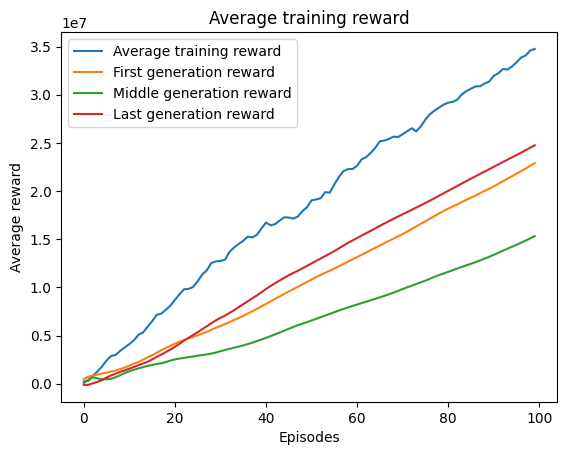

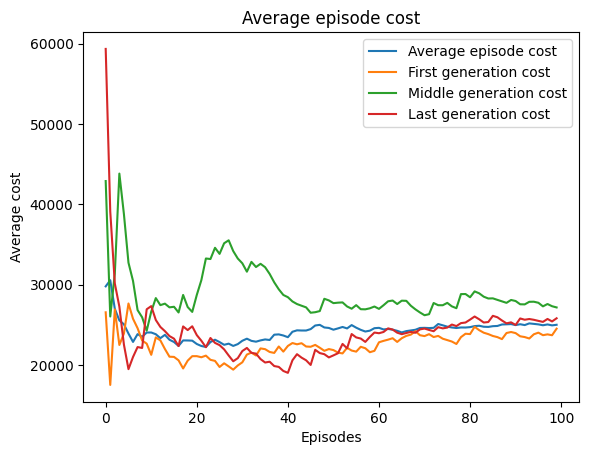

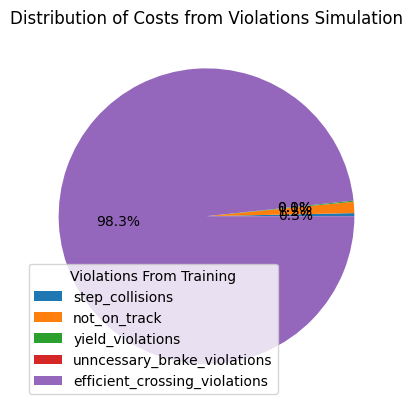

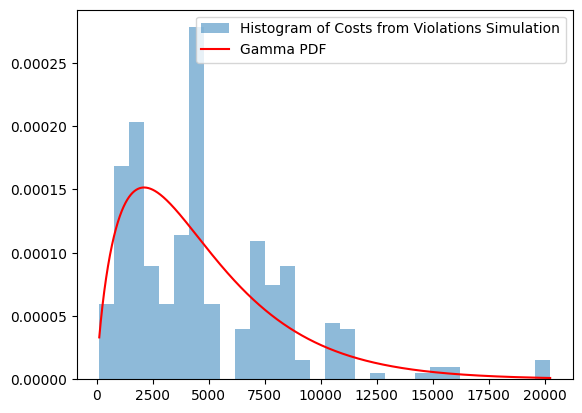

Kolmogorov-Smirnov test: D = 0.07529628095404384, p-value = 0.06325138966869581
Kolmogorov-Smirnov test: D = 0.07529628095404384, p-value = 0.06325138966869581
Standard Deviation: 3532.945026392838
25th percentile: 1961.5
Median: 4148.5
75th percentile: 7187.5
KS statistic: 0.07529628095404384
KS p-value: 0.06325138966869581


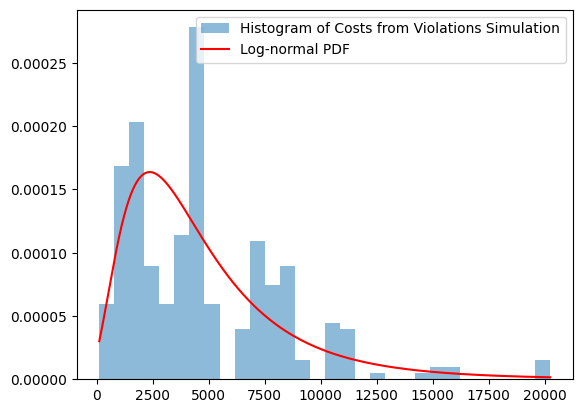

Kolmogorov-Smirnov test: D = 0.07400301486198291, p-value = 0.07109538832703621
Standard Deviation: 3532.945026392838
25th percentile: 1961.5
Median: 4148.5
75th percentile: 7187.5
KS statistic: 0.07400301486198291
KS p-value: 0.07109538832703621


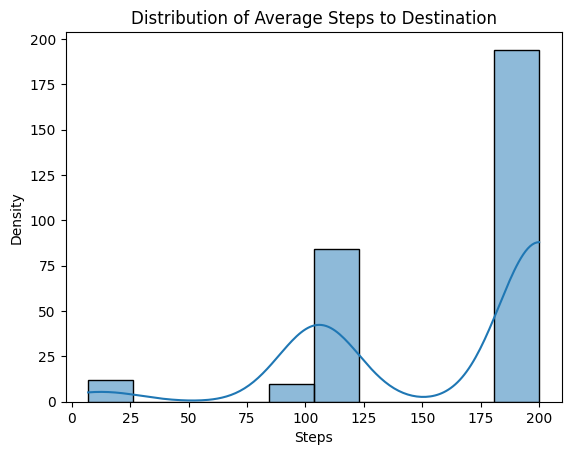

Mean: 163.00333333333333
Standard Deviation: 53.06076694591672
25th percentile: 106.5
Median: 200.0
75th percentile: 200.0
Skewness: -2.0917526524471244
Kurtosis: 8916.624791146278


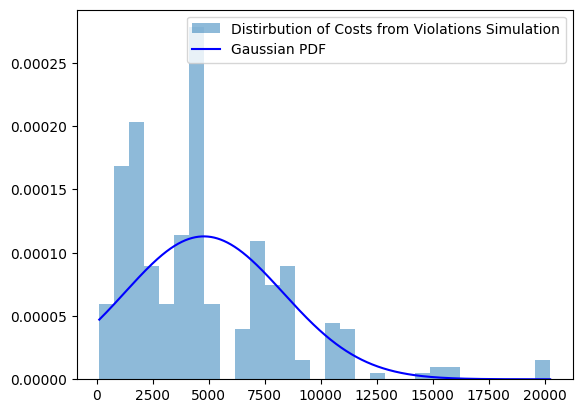

Kolmogorov-Smirnov test: D = 0.17327665455021535, p-value = 2.3959807697330788e-08
The mean of the normal distribution is 4781.608333333334
The 25th percentile of the normal distribution is 2398.673125025139
The 50th percentile of the normal distribution is 4781.608333333334
The 75th percentile of the normal distribution is 7164.543541641528
The 95th percentile of the normal distribution is 10592.785773815758
The 99th percentile of the normal distribution is 13000.467484585473
The correlation between 'costs_from_violations_smooth' and 'at_dest_f' is 0.40716072113885443


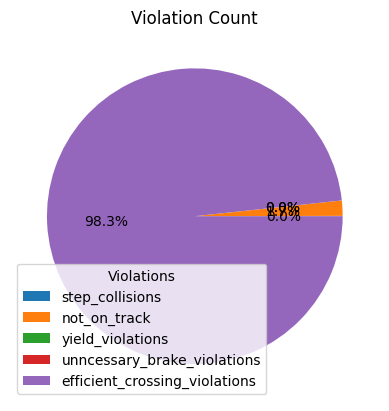

In [ ]:
avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f = None, None, None, None, None, None, None, None
for seed in seeds:
    avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs = simulation_10_to_4_agents(seed, False) 
    if seed == seeds[0]:
        avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f= avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs
        first_gen_results_f = [list(item) for item in first_gen_results_f]
        middle_gen_results_f = [list(item) for item in middle_gen_results_f]
        last_gen_results_f = [list(item) for item in last_gen_results_f]
    
    else:
        avg_training_rewards_f = [sum(x) / 2 for x in zip(avg_training_rewards_f, avg_training_rewards)]
       
        avg_episode_costs_f = [sum(x) / 2 for x in zip(avg_episode_costs_f, avg_episode_costs)]

        first_gen_results_f[0][0] = [sum(x) / 2 for x in zip(first_gen_results_f[0][0], first_gen_results[0][0])]
        middle_gen_results_f[0][0] = [sum(x) / 2 for x in zip(middle_gen_results_f[0][0], middle_gen_results[0][0])]
        last_gen_results_f[0][0] = [sum(x) / 2 for x in zip(last_gen_results_f[0][0], last_gen_results[0][0])]

        avg_training_norm_violations_f = avg_training_norm_violations_f.add(avg_training_norm_violations).div(2)
        
        first_gen_results_f[0][1] = first_gen_results_f[0][1].add(first_gen_results[0][1]).div(2)
        middle_gen_results_f[0][1] = middle_gen_results_f[0][1].add(middle_gen_results[0][1]).div(2)
        last_gen_results_f[0][1] = last_gen_results_f[0][1].add(last_gen_results[0][1]).div(2)

        sim_violated_f = sim_violated_f.add(sim_violated).div(2)
        at_dest_f = [sum(x) / 2 for x in zip(at_dest_f, at_dest)]

#plot results
avg_results = pd.Series(avg_training_rewards_f).ewm(span=125).mean()
first_results = pd.Series(first_gen_results_f[0][0]).ewm(span=125).mean()   
middle_results = pd.Series(middle_gen_results_f[0][0]).ewm(span=125).mean()
last_results = pd.Series(last_gen_results_f[0][0]).ewm(span=125).mean()
print(f"Last results: {last_gen_results_f[0][0]}")
print(f"Last results series: {last_results}")
plt.plot(avg_training_rewards_f, label='Average training reward')
plt.plot(first_results, label='First generation reward')
plt.plot(middle_results, label='Middle generation reward')
plt.plot(last_results, label='Last generation reward')
plt.legend()
plt.title('Average training reward')
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()

#AVERAGE EPISODE COSTS OVER GENERATIONS AND SEEDS
#.ewm(span=300).mean()
avg_episode_costs_f = [-1 * x for x in avg_episode_costs_f]
avg_episode_costs_f = pd.Series(avg_episode_costs_f).ewm(span=125).mean()
first_gen_results_f[0][2] = [-1 * x for x in first_gen_results_f[0][2]]
first_gen_results_f[0][2] = pd.Series(first_gen_results_f[0][2]).ewm(span=125).mean()
middle_gen_results_f[0][2] = [-1 * x for x in middle_gen_results_f[0][2]]
middle_gen_results_f[0][2] = pd.Series(middle_gen_results_f[0][2]).ewm(span=125).mean()
last_gen_results_f[0][2] = [-1 * x for x in last_gen_results_f[0][2]]
last_gen_results_f[0][2] = pd.Series(last_gen_results_f[0][2]).ewm(span=125).mean()
plt.plot(avg_episode_costs_f, label='Average episode cost')
plt.plot(first_gen_results_f[0][2], label='First generation cost')
plt.plot(middle_gen_results_f[0][2], label='Middle generation cost')
plt.plot(last_gen_results_f[0][2], label='Last generation cost')
plt.legend()
plt.title('Average episode cost')
plt.xlabel('Episodes')
plt.ylabel('Average cost')
plt.show()
#training violations 
first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("seed", axis=1)
first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("total_violations_cost", axis=1)
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("seed", axis=1)    
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("total_violations_cost", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("seed", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("total_violations_cost", axis=1)


#pie chart of violations training
avg_training_norm_violations_f = avg_training_norm_violations_f.drop("seed", axis=1)   
avg_training_norm_violations_f = avg_training_norm_violations_f.drop("total_violations_cost", axis=1)

violation_counts = avg_training_norm_violations_f.sum()
violation_counts = violation_counts.clip(lower=0)
plt.pie(violation_counts, autopct='%1.1f%%')
plt.title('Violation Count')
plt.legend(violation_counts.index, title="Violations From Training", loc="best")


costs_from_violations_f = copy.deepcopy(sim_violated_f['total_violations_cost'])
sim_violated_f.drop(columns=['seed'], inplace=True)
sim_violated_f.drop(columns=['total_violations_cost'], inplace=True)
costs_from_violations = -1 * costs_from_violations_f
costs_from_violations_smooth = pd.Series(costs_from_violations).rolling(window=window_size2).mean()

sns.histplot(costs_from_violations, kde=True)
plt.title('Distribution of Costs from Violations Simulation')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

data = costs_from_violations

shape, loc, scale = gamma.fit(data)

x = np.linspace(min(data), max(data), 10000)

pdf = gamma.pdf(x, shape, loc, scale)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Gamma PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
mean = np.mean(data)
std_dev = np.std(data)

percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")


shape, loc, scale = lognorm.fit(data)

pdf = lognorm.pdf(x, shape, loc, scale)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Log-normal PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
mean = np.mean(data)
std_dev = np.std(data)

percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")



at_dest_f = np.array(at_dest_f)
sns.histplot(at_dest_f, kde=True)
plt.title('Distribution of Average Steps to Destination')
plt.xlabel('Steps')
plt.ylabel('Density')
plt.show()

mean = np.mean(at_dest_f)
std_dev = np.std(at_dest_f)
percentiles = np.percentile(at_dest_f, [25, 50, 75])
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
#skewness
skewness = (3*(mean - np.median(at_dest_f)))/std_dev
print(f"Skewness: {skewness}")
#kurtosis
kurtosis = (np.mean((at_dest_f - np.mean(at_dest_f))**4)/(np.mean((at_dest_f - np.mean(at_dest_f))**2)))-3
print(f"Kurtosis: {kurtosis}")


pdf_lognorm = lognorm.pdf(x, shape, loc, scale)

mean, std_dev = np.mean(data), np.std(data)
pdf_gaussian = norm.pdf(x, mean, std_dev)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Distirbution of Costs from Violations Simulation')
plt.plot(x, pdf_gaussian, 'b-', label='Gaussian PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'norm', args=(mean, std_dev))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")

print(f"The mean of the normal distribution is {mean}")
print(f"The 25th percentile of the normal distribution is {norm.ppf(0.25, mean, std_dev)}")
print(f"The 50th percentile of the normal distribution is {norm.ppf(0.50, mean, std_dev)}")
print(f"The 75th percentile of the normal distribution is {norm.ppf(0.75, mean, std_dev)}")
print(f"The 95th percentile of the normal distribution is {norm.ppf(0.95, mean, std_dev)}")
print(f"The 99th percentile of the normal distribution is {norm.ppf(0.99, mean, std_dev)}")





df = pd.DataFrame({
    'costs_from_violations_smooth': costs_from_violations,
    'at_dest_f': at_dest_f
})

correlation = df['costs_from_violations_smooth'].corr(df['at_dest_f'])

print(f"The correlation between 'costs_from_violations_smooth' and 'at_dest_f' is {correlation}")
violation_counts = sim_violated_f.sum()


plt.pie(violation_counts, autopct='%1.1f%%')

plt.title('Violation Count')

plt.legend(violation_counts.index, title="Violations", loc="best")

plt.show()




## 10 Agents

Generation 1/300


/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Solving for Nash Equilibrium in Generation 1/300
Computing Nash Equilibrium for 100 matches
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Ep

/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Overriding environment TrafficJunction4-v0
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/homebrew/lib/python3.11/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Solving for Nash Equilibrium in Generation 1/300
Computing Nash Equilibrium for 100 matches
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Ep

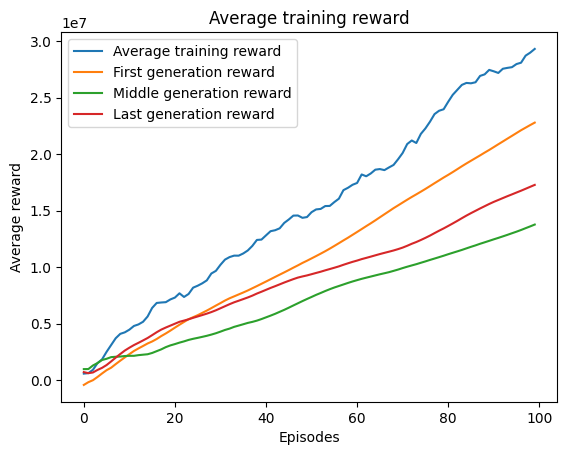

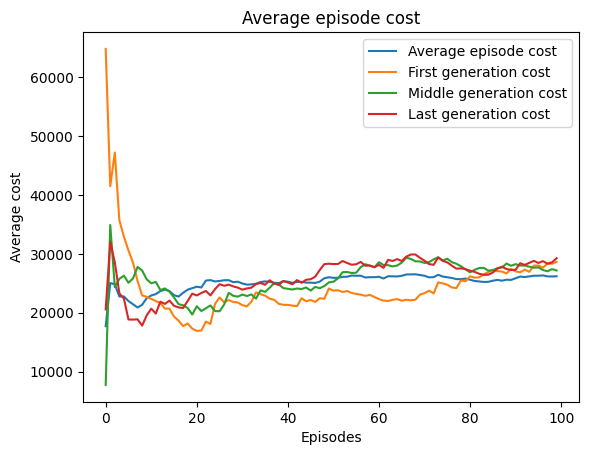

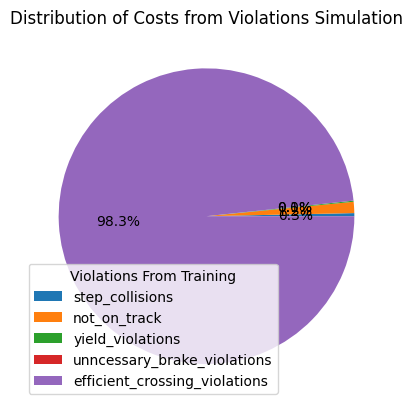

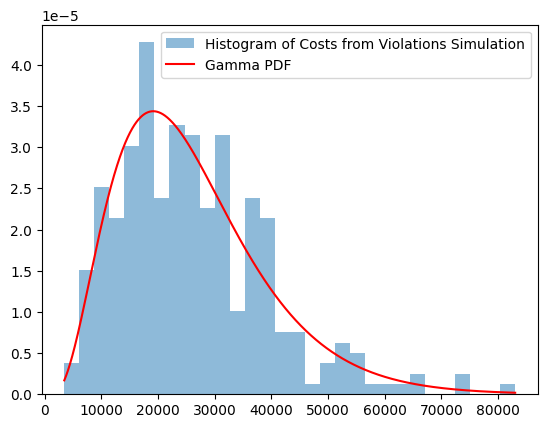

Kolmogorov-Smirnov test: D = 0.03232721149215734, p-value = 0.9022852830922347
Kolmogorov-Smirnov test: D = 0.03232721149215734, p-value = 0.9022852830922347
Standard Deviation: 13207.866139082189
25th percentile: 16677.5625
Median: 24325.125
75th percentile: 33314.0625
KS statistic: 0.03232721149215734
KS p-value: 0.9022852830922347


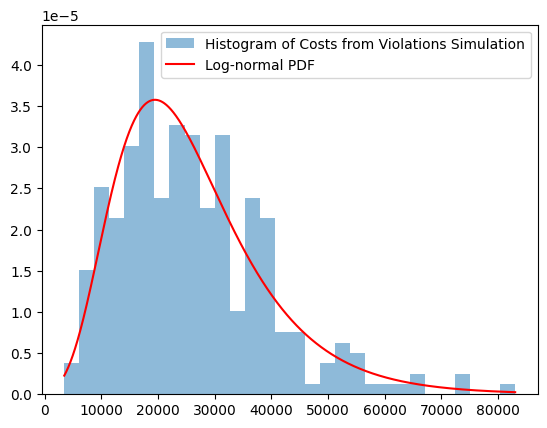

Kolmogorov-Smirnov test: D = 0.03425989340297442, p-value = 0.8607214179576708
Standard Deviation: 13207.866139082189
25th percentile: 16677.5625
Median: 24325.125
75th percentile: 33314.0625
KS statistic: 0.03425989340297442
KS p-value: 0.8607214179576708


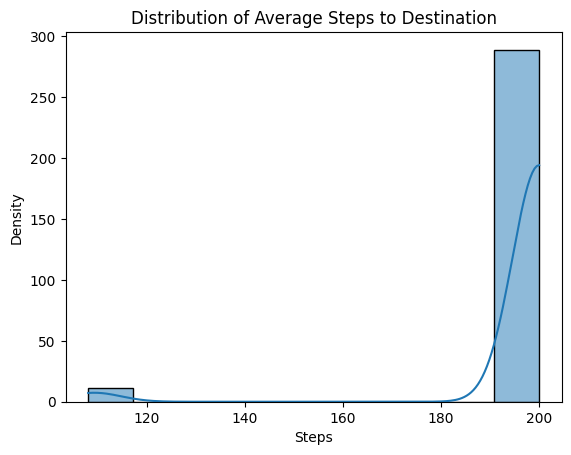

Mean: 196.67166666666665
Standard Deviation: 17.06022754505018
25th percentile: 200.0
Median: 200.0
75th percentile: 200.0
Skewness: -0.5852794151562809
Kurtosis: 7364.525090559289


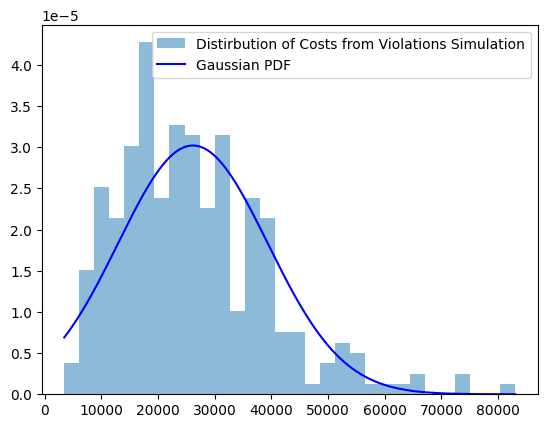

Kolmogorov-Smirnov test: D = 0.07126659690274201, p-value = 0.09044153881518513
The mean of the normal distribution is 26183.168333333335
The 25th percentile of the normal distribution is 17274.5980005605
The 50th percentile of the normal distribution is 26183.168333333335
The 75th percentile of the normal distribution is 35091.73866610617
The 95th percentile of the normal distribution is 47908.174856492216
The 99th percentile of the normal distribution is 56909.2596466032
The correlation between 'costs_from_violations_smooth' and 'at_dest_f' is 0.196374330382139


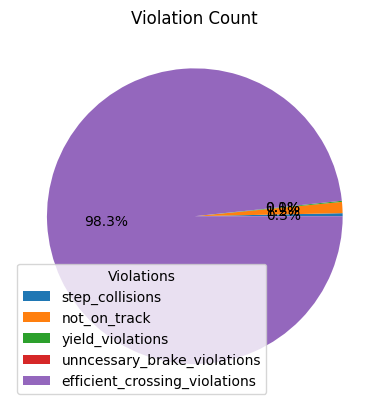

In [ ]:
avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f = None, None, None, None, None, None, None, None
for seed in seeds:
    avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs = simulation_10_agents(seed, False) 
    if seed == seeds[0]:
        avg_training_rewards_f, avg_training_norm_violations_f, sim_violated_f, at_dest_f, first_gen_results_f, middle_gen_results_f, last_gen_results_f, avg_episode_costs_f= avg_training_rewards, avg_training_norm_violations, sim_violated, at_dest, first_gen_results, middle_gen_results, last_gen_results, avg_episode_costs
        first_gen_results_f = [list(item) for item in first_gen_results_f]
        middle_gen_results_f = [list(item) for item in middle_gen_results_f]
        last_gen_results_f = [list(item) for item in last_gen_results_f]
    
    else:
        avg_training_rewards_f = [sum(x) / 2 for x in zip(avg_training_rewards_f, avg_training_rewards)]
       
        avg_episode_costs_f = [sum(x) / 2 for x in zip(avg_episode_costs_f, avg_episode_costs)]

        first_gen_results_f[0][0] = [sum(x) / 2 for x in zip(first_gen_results_f[0][0], first_gen_results[0][0])]
        middle_gen_results_f[0][0] = [sum(x) / 2 for x in zip(middle_gen_results_f[0][0], middle_gen_results[0][0])]
        last_gen_results_f[0][0] = [sum(x) / 2 for x in zip(last_gen_results_f[0][0], last_gen_results[0][0])]

        avg_training_norm_violations_f = avg_training_norm_violations_f.add(avg_training_norm_violations).div(2)
        
        first_gen_results_f[0][1] = first_gen_results_f[0][1].add(first_gen_results[0][1]).div(2)
        middle_gen_results_f[0][1] = middle_gen_results_f[0][1].add(middle_gen_results[0][1]).div(2)
        last_gen_results_f[0][1] = last_gen_results_f[0][1].add(last_gen_results[0][1]).div(2)

        sim_violated_f = sim_violated_f.add(sim_violated).div(2)
        at_dest_f = [sum(x) / 2 for x in zip(at_dest_f, at_dest)]

#plot results
avg_results = pd.Series(avg_training_rewards_f).ewm(span=125).mean()
first_results = pd.Series(first_gen_results_f[0][0]).ewm(span=125).mean()   
middle_results = pd.Series(middle_gen_results_f[0][0]).ewm(span=125).mean()
last_results = pd.Series(last_gen_results_f[0][0]).ewm(span=125).mean()
print(f"Last results: {last_gen_results_f[0][0]}")
print(f"Last results series: {last_results}")
plt.plot(avg_training_rewards_f, label='Average training reward')
plt.plot(first_results, label='First generation reward')
plt.plot(middle_results, label='Middle generation reward')
plt.plot(last_results, label='Last generation reward')
plt.legend()
plt.title('Average training reward')
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()


avg_episode_costs_f = [-1 * x for x in avg_episode_costs_f]
avg_episode_costs_f = pd.Series(avg_episode_costs_f).ewm(span=125).mean()
first_gen_results_f[0][2] = [-1 * x for x in first_gen_results_f[0][2]]
first_gen_results_f[0][2] = pd.Series(first_gen_results_f[0][2]).ewm(span=125).mean()
middle_gen_results_f[0][2] = [-1 * x for x in middle_gen_results_f[0][2]]
middle_gen_results_f[0][2] = pd.Series(middle_gen_results_f[0][2]).ewm(span=125).mean()
last_gen_results_f[0][2] = [-1 * x for x in last_gen_results_f[0][2]]
last_gen_results_f[0][2] = pd.Series(last_gen_results_f[0][2]).ewm(span=125).mean()
plt.plot(avg_episode_costs_f, label='Average episode cost')
plt.plot(first_gen_results_f[0][2], label='First generation cost')
plt.plot(middle_gen_results_f[0][2], label='Middle generation cost')
plt.plot(last_gen_results_f[0][2], label='Last generation cost')
plt.legend()
plt.title('Average episode cost')
plt.xlabel('Episodes')
plt.ylabel('Average cost')
plt.show()

first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("seed", axis=1)
first_gen_results_f[0][1] = first_gen_results_f[0][1].drop("total_violations_cost", axis=1)
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("seed", axis=1)    
middle_gen_results_f[0][1] = middle_gen_results_f[0][1].drop("total_violations_cost", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("seed", axis=1)
last_gen_results_f[0][1] = last_gen_results_f[0][1].drop("total_violations_cost", axis=1)


avg_training_norm_violations_f = avg_training_norm_violations_f.drop("seed", axis=1)   
avg_training_norm_violations_f = avg_training_norm_violations_f.drop("total_violations_cost", axis=1)

violation_counts = avg_training_norm_violations_f.sum()
violation_counts = violation_counts.clip(lower=0)
plt.pie(violation_counts, autopct='%1.1f%%')
plt.title('Violation Count')
plt.legend(violation_counts.index, title="Violations From Training", loc="best")


costs_from_violations_f = copy.deepcopy(sim_violated_f['total_violations_cost'])
sim_violated_f.drop(columns=['seed'], inplace=True)
sim_violated_f.drop(columns=['total_violations_cost'], inplace=True)
costs_from_violations = -1 * costs_from_violations_f
costs_from_violations_smooth = pd.Series(costs_from_violations).rolling(window=window_size2).mean()

sns.histplot(costs_from_violations, kde=True)
plt.title('Distribution of Costs from Violations Simulation')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

data = costs_from_violations

shape, loc, scale = gamma.fit(data)

x = np.linspace(min(data), max(data), 10000)

pdf = gamma.pdf(x, shape, loc, scale)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Gamma PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
mean = np.mean(data)
std_dev = np.std(data)

percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")


shape, loc, scale = lognorm.fit(data)

pdf = lognorm.pdf(x, shape, loc, scale)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Costs from Violations Simulation')
plt.plot(x, pdf, 'r-', label='Log-normal PDF')
plt.legend()
plt.show()

d, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
mean = np.mean(data)
std_dev = np.std(data)

percentiles = np.percentile(data, [25, 50, 75])
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
print(f"KS statistic: {d}")
print(f"KS p-value: {p_value}")

at_dest_f = np.array(at_dest_f)
sns.histplot(at_dest_f, kde=True)
plt.title('Distribution of Average Steps to Destination')
plt.xlabel('Steps')
plt.ylabel('Density')
plt.show()

mean = np.mean(at_dest_f)
std_dev = np.std(at_dest_f)
percentiles = np.percentile(at_dest_f, [25, 50, 75])
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"25th percentile: {percentiles[0]}")
print(f"Median: {percentiles[1]}")
print(f"75th percentile: {percentiles[2]}")
#skewness
skewness = (3*(mean - np.median(at_dest_f)))/std_dev
print(f"Skewness: {skewness}")
#kurtosis
kurtosis = (np.mean((at_dest_f - np.mean(at_dest_f))**4)/(np.mean((at_dest_f - np.mean(at_dest_f))**2)))-3
print(f"Kurtosis: {kurtosis}")


pdf_lognorm = lognorm.pdf(x, shape, loc, scale)

mean, std_dev = np.mean(data), np.std(data)
pdf_gaussian = norm.pdf(x, mean, std_dev)

# Plot the histogram of your data, the log-normal PDF, and the Gaussian PDF
plt.hist(data, bins=30, density=True, alpha=0.5, label='Distirbution of Costs from Violations Simulation')
plt.plot(x, pdf_gaussian, 'b-', label='Gaussian PDF')
plt.legend()
plt.show()

# Perform the Kolmogorov-Smirnov test
d, p_value = kstest(data, 'norm', args=(mean, std_dev))
print(f"Kolmogorov-Smirnov test: D = {d}, p-value = {p_value}")

print(f"The mean of the normal distribution is {mean}")
print(f"The 25th percentile of the normal distribution is {norm.ppf(0.25, mean, std_dev)}")
print(f"The 50th percentile of the normal distribution is {norm.ppf(0.50, mean, std_dev)}")
print(f"The 75th percentile of the normal distribution is {norm.ppf(0.75, mean, std_dev)}")
print(f"The 95th percentile of the normal distribution is {norm.ppf(0.95, mean, std_dev)}")
print(f"The 99th percentile of the normal distribution is {norm.ppf(0.99, mean, std_dev)}")





df = pd.DataFrame({
    'costs_from_violations_smooth': costs_from_violations,
    'at_dest_f': at_dest_f
})

correlation = df['costs_from_violations_smooth'].corr(df['at_dest_f'])

print(f"The correlation between 'costs_from_violations_smooth' and 'at_dest_f' is {correlation}")
violation_counts = sim_violated_f.sum()


plt.pie(violation_counts, autopct='%1.1f%%')

plt.title('Violation Count')

plt.legend(violation_counts.index, title="Violations", loc="best")

plt.show()
